Currently this does not work.

* [DCGAN - advise on why the training is not working](https://datascience.stackexchange.com/questions/94708/dcgan-advise-on-why-the-training-is-not-working)

# References

* [Deep-Learning-with-TensorFlow-2-and-Keras/Chapter 6/DCGAN.ipynb
](https://github.com/PacktPublishing/Deep-Learning-with-TensorFlow-2-and-Keras/blob/master/Chapter%206/DCGAN.ipynb)

* [CIFAR10 DCGAN Example](https://www.kaggle.com/laszlofazekas/cifar10-dcgan-example)

* [How to Develop a GAN to Generate CIFAR10 Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)


* [DC GAN with Batch Normalization not working](https://datascience.stackexchange.com/a/56891/68313)



In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Reshape,
    Dense, 
    Dropout, 
    Flatten, 
    UpSampling2D,
    ZeroPadding2D, 
    Conv2D,
    BatchNormalization,
    Activation,
    LeakyReLU
)
from tensorflow.keras.optimizers import Adam

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

TensorFlow version: 2.4.1
Eager execution is: True
Keras version: 2.4.0


In [2]:
!rm -rf images
!mkdir images

# CIFAR

In [3]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CHANNELS = 3

In [4]:
def plot_cifar10_image(image, width, height, channels):
    reshaped = image.reshape(width, height, channels)
    plt.figure(figsize=(1,1)),
    plt.imshow(reshaped, cmap=plt.cm.binary)
    plt.axis("off")
    
def plot_cifar10_images(instances, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, channels=NUM_CHANNELS, images_per_row=5, figsize=(6,6), **options):
    plt.figure(figsize=figsize)

    images_per_row = min(len(instances), images_per_row)
    images = [np.reshape(instance, (width, height, channels)) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((width, width * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

def save_images(images, r, c, epoch):
    # scale from [-1,1] to [0,1]
    USE_NORM=False
    if USE_NORM:
        images = tf.math.divide(
            tf.math.subtract(
                images, 
                tf.reduce_min(images)
            ), 
            tf.math.subtract(
                tf.reduce_max(images), 
                tf.reduce_min(images)
            )
        )
    else:
        images = (images + 1.0) / 2.0

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            #axs[i,j].imshow(gen_imgs[cnt], cmap=mpl.cm.binary)
            axs[i,j].imshow(images[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/drive/MyDrive/dcgan_cifar10_%d.png" % epoch)
    plt.close()

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = tf.concat((x_train, x_test), axis=0)

In [6]:
print(x_train[0].shape)
print(x_train.shape)
print(x_train.dtype)

(32, 32, 3)
(60000, 32, 32, 3)
<dtype: 'uint8'>


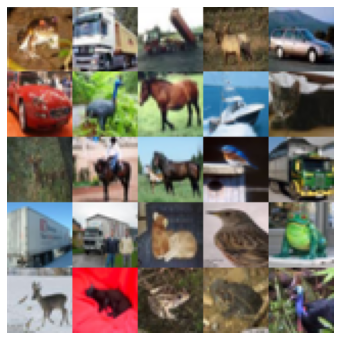

In [7]:
plot_cifar10_images(x_train[0:25], IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)

## Data Normalization

In [8]:
X = tf.cast(x_train, dtype='float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

# DCGAN

In [24]:
class DCGAN():
    def __init__(self, dataset, rows, cols, channels, latent_dim = 100, batch_size=256):
        # data
        self.dataset = dataset
        self.batch_size = batch_size
        
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )

        # Build the generator
        self.generator = self.build_generator()
        self.generator.trainable = True

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the gan model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The gan model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.gan = Model(z, valid)
        self.gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    # select real samples
    def generate_real_samples(self, n_samples):
        # choose random instances
        indices = tf.random.uniform(
            shape=[n_samples, 1], 
            minval=0,
            maxval=self.dataset.shape[0], 
            dtype=tf.int32
        )
        X = tf.gather_nd(self.dataset, indices)
        y = tf.ones([n_samples,1])    # label 1
        return X, y        

    def generate_random_noise(self, n_samples):
        Z = tf.random.normal(
            shape=(n_samples, self.latent_dim),
            mean=0.0, 
            stddev=1.0, 
            dtype=tf.dtypes.float32, 
            seed=None
        )
        return Z

    # generate fake samples
    def generate_fake_samples(self, n_samples):
        # noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
        Z = self.generate_random_noise(n_samples)              
        X = self.generator.predict(Z)
        y = tf.zeros([n_samples,1])    # label 0

        return X, y

    def build_generator(self):
        model = Sequential()

        model.add(Dense(4 * 4 * self.batch_size, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((4, 4, self.batch_size)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, save_interval=50):
        for epoch in range(epochs):
             # If at save interval => save generated image samples
            for batch in range(self.dataset.shape[0] // self.batch_size + 1):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Select a random half of true images
                reals, true_labels = self.generate_real_samples(self.batch_size)
                fakes, false_labels = self.generate_fake_samples(self.batch_size)

                # Sample noise and generate a batch of fake images

                # Train the discriminator (real as 1 and generated as 0)'
                self.discriminator.trainable = True
                d_loss_real = self.discriminator.train_on_batch(reals, true_labels)
                d_loss_fake = self.discriminator.train_on_batch(fakes, false_labels)
                d_loss = tf.math.divide(tf.add(d_loss_real, d_loss_fake), 2.0)

                # ---------------------
                #  Train Generator
                # ---------------------
                # Train the generator (for discriminator to mistake fake as real)
                self.discriminator.trainable = False
                self.generator.trainable = True
                Z = self.generate_random_noise(self.batch_size) 
                g_loss = self.gan.train_on_batch(Z, true_labels)

            # Plot the progress
            print(
                "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                (epoch, d_loss[0], 100*d_loss[1], g_loss)
            )
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        Z = self.generate_random_noise(r*c) 
        images = self.generator.predict(Z)
        save_images(images, r, c, epoch)

    def save(self, path_to_dir):
        self.generator.save(filepath=path_to_dir + "/generator", overwrite=True)
        self.discriminator.save(filepath=path_to_dir + "/discriminator", overwrite=True)
        self.gan.save(filepath=path_to_dir + "/gan", overwrite=True)


In [25]:
dcgan = DCGAN(
    dataset=X, 
    rows=32,
    cols=32,
    channels=3,    
    latent_dim=100,
    batch_size=256,
)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 8, 8, 128)       

In [ ]:
dcgan.train(epochs=50, save_interval=1)
dcgan.save("/content/drive/MyDrive")

0 [D loss: 0.000902, acc.: 100.00%] [G loss: 0.079684]
1 [D loss: 0.000259, acc.: 100.00%] [G loss: 0.016727]
2 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.006980]
3 [D loss: 0.000067, acc.: 100.00%] [G loss: 0.004806]
4 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.006730]
